In [1]:
#Sistem kütüphaneleri
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
#Pre-prossesing kütüphaneleri
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Deep Learning kütüphaneleri
import tensorflow as tf 
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


In [2]:
# Verisetini yükleme ve ön işleme adımlarını uygulama.
data = r"C:\Users\oem\lung_colon_image_set"
file_paths = []
labels = []

# Verisetindeki klasörleri dolaşma
folds = os.listdir(data)
for fold in folds:
    foldpath = os.path.join(data, fold)
    flist = os.listdir(foldpath)
    for f in flist:
        f_path = os.path.join(foldpath, f)
        filelist = os.listdir(f_path)
        for file in filelist:
            fpath = os.path.join(f_path, file)
            file_paths.append(fpath)
            # Veri etiketlerini belirleme
            if f == 'colon_aca':
                labels.append('Kolon Adenokarsinomu')
            elif f == 'colon_n':
                labels.append('Kolon İyi Huylu Dokusu')
            elif f == 'lung_aca':
                labels.append('Akciğer Adenokarsinomu')
            elif f == 'lung_n':
                labels.append('Akciğer İyi Huylu Dokusu')
            elif f == 'lung_scc':
                labels.append('Akciğer Skuamöz Hücreli Karsinom')

Fseries = pd.Series(file_paths, name = 'filepaths')
Lseries = pd.Series(labels, name='labels')
df= pd.concat([Fseries, Lseries], axis = 1)

In [3]:
#Listeleme işlemi yapma
df

filepaths  \
0      C:\Users\oem\lung_colon_image_set\colon_image_...   
1      C:\Users\oem\lung_colon_image_set\colon_image_...   
2      C:\Users\oem\lung_colon_image_set\colon_image_...   
3      C:\Users\oem\lung_colon_image_set\colon_image_...   
4      C:\Users\oem\lung_colon_image_set\colon_image_...   
...                                                  ...   
24995  C:\Users\oem\lung_colon_image_set\lung_image_s...   
24996  C:\Users\oem\lung_colon_image_set\lung_image_s...   
24997  C:\Users\oem\lung_colon_image_set\lung_image_s...   
24998  C:\Users\oem\lung_colon_image_set\lung_image_s...   
24999  C:\Users\oem\lung_colon_image_set\lung_image_s...   

                                 labels  
0                  Kolon Adenokarsinomu  
1                  Kolon Adenokarsinomu  
2                  Kolon Adenokarsinomu  
3                  Kolon Adenokarsinomu  
4                  Kolon Adenokarsinomu  
...                                 ...  
24995  Akciğer Skuamöz Hücreli Karsinom  
24996  Akciğer Skuamöz Hücreli Karsinom  
24997  Akciğer Skuamöz Hücreli Karsinom  
24998  Akciğer Skuamöz Hücreli Karsinom  
24999  Akciğer Skuamöz Hücreli Karsinom  

[25000 rows x 2 columns]

In [4]:
#Verisetini train ve test olarak yüzde 80 oranında ayırlır.
strat = df['labels']
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42, stratify=strat)

#Verisetini tekrar doğrulama amacıyla yüzde 50 oranında ayrılır.
strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df, train_size = 0.5, shuffle=True, random_state=42,stratify=strat)

In [5]:
#Modelin eğitim ve doğrulaması için görüntüleri hazırlama işlemi 
batch_size=64
img_size=(224,224)
channels = 3 
img_shape=(img_size[0],img_size[1], channels)
tr_gen=ImageDataGenerator()
ts_gen=ImageDataGenerator()
train_gen=tr_gen.flow_from_dataframe(train_df,x_col='filepaths',
                                     y_col='labels',target_size=img_size,class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size = batch_size)

valid_gen=ts_gen.flow_from_dataframe(valid_df,x_col='filepaths',
                                     y_col='labels',target_size=img_size,class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size = batch_size)
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


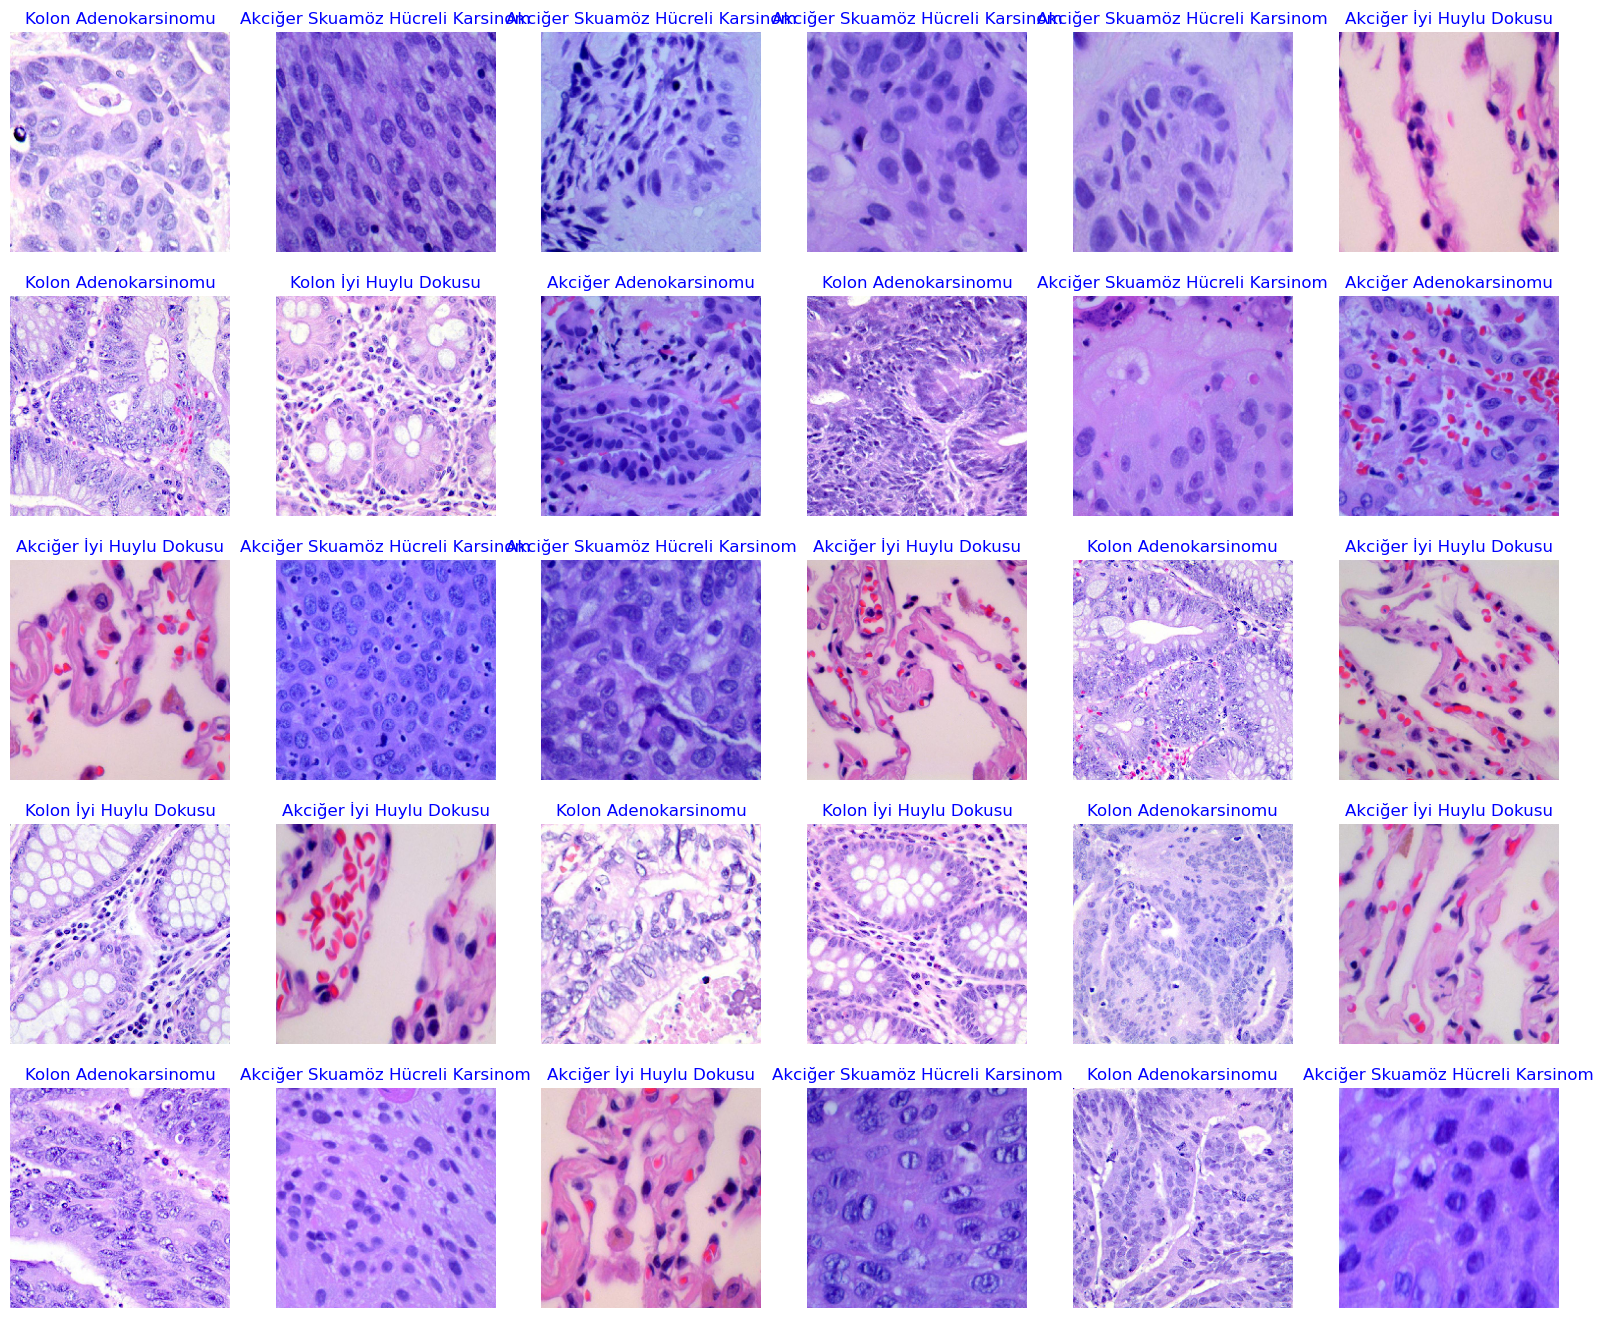

In [6]:
#Görüntüleri ve etiketleri görselleştirme
g_dict = train_gen.class_indices
classes=list(g_dict.keys())
images, labels = next(train_gen)
plt.figure(figsize = (20,20))

for i in range(30):
    plt.subplot(6,6,i+1)
    image = images[i]/255
    plt.imshow(image)
    index=np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color = 'blue', fontsize=12)
    plt.axis('off')

plt.show()    

In [7]:
#Modeli oluşturma, tanımlama, derlenme ve eğitilme aşaması.
img_size = (224,224)
channels = 3
img_shape = (img_size[0], img_size[1],channels)
class_count = len(list(train_gen.class_indices.keys()))
#Görüntülerden özellikler çıkarmak ve boyutunu azaltmak için Conv2D e Maxpooling2D katmanlarını kullanıldı.
#Özellikleri sınıflandırmak için Flatten fonkisyonu ve katmanlar (dense) eklendi.

model =  Sequential([
    Conv2D(filters = 64, kernel_size=(3,3),padding="same", activation="relu",input_shape=img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2,2)),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
        Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
        Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
     Flatten(),
    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(class_count, activation = "softmax")
])
#Modelin derlenmesi işlemi.
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [8]:
#Modelin eğitim aşaması. 20 kez tekrar edecek ve kayıp, başarı değerlerini verecek.
epochs = 20
history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/20
313/313 [==============================] - 26009s 83s/step - loss: 4.2090 - accuracy: 0.6684 - val_loss: 0.3501 - val_accuracy: 0.8472
Epoch 2/20
313/313 [==============================] - 25720s 82s/step - loss: 0.2770 - accuracy: 0.8896 - val_loss: 0.1682 - val_accuracy: 0.9352
Epoch 3/20
313/313 [==============================] - 25659s 82s/step - loss: 0.1859 - accuracy: 0.9294 - val_loss: 0.1337 - val_accuracy: 0.9448
Epoch 4/20
313/313 [==============================] - 26667s 85s/step - loss: 0.1483 - accuracy: 0.9427 - val_loss: 0.1795 - val_accuracy: 0.9260
Epoch 5/20
313/313 [==============================] - 26231s 84s/step - loss: 0.1193 - accuracy: 0.9513 - val_loss: 0.1025 - val_accuracy: 0.9572
Epoch 6/20
313/313 [==============================] - 28125s 90s/step - loss: 0.1026 - accuracy: 0.9604 - val_loss: 0.1358 - val_accuracy: 0.9464
Epoch 7/20
313/313 [==============================] - 26419s 84s/step - loss: 0.0843 - accuracy: 0.9678 - val_loss: 0.0933 -

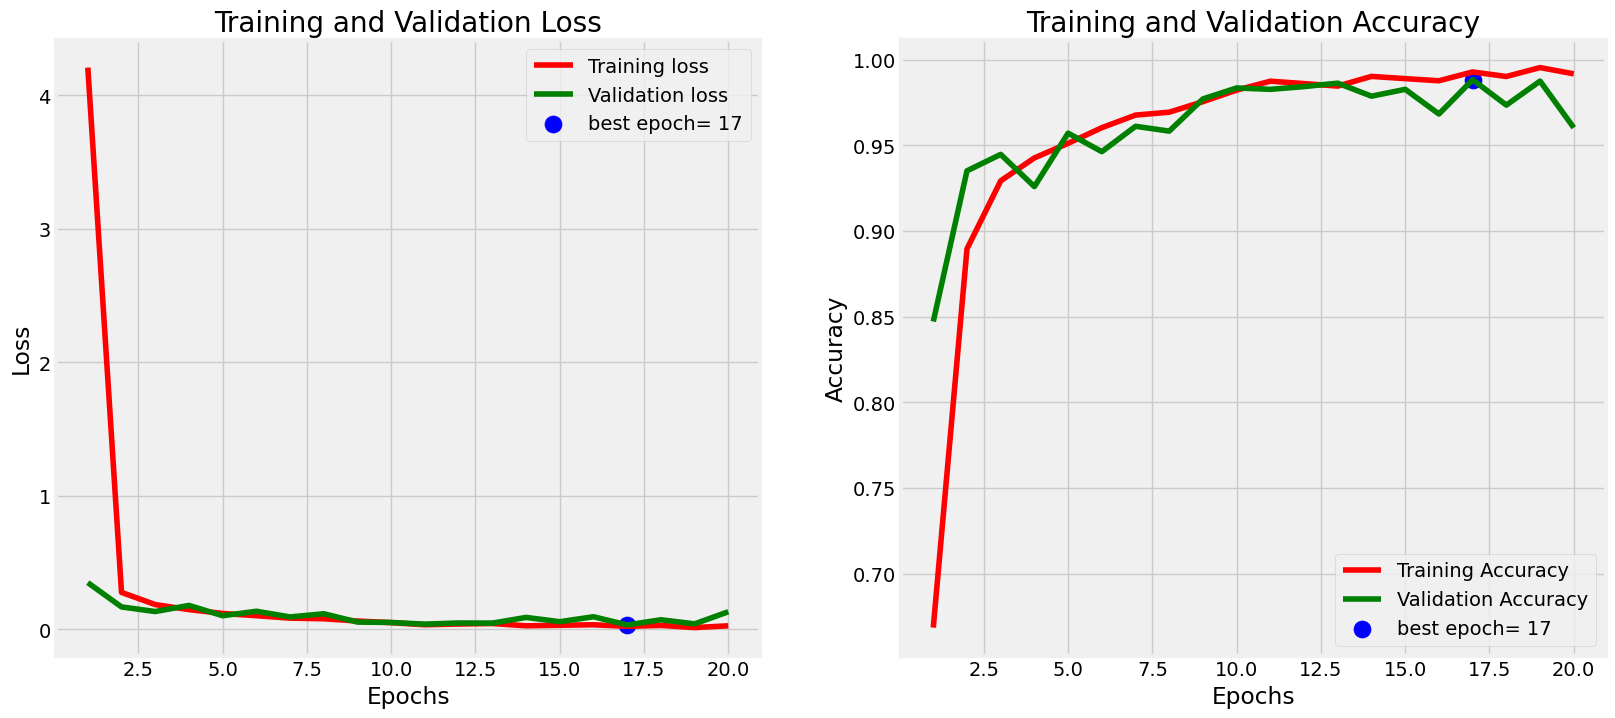

In [9]:
# Accuracy loss değerlerinin atanması ve grafik oluşturulması. 
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

#Grafik görselleştirme işlemi 
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


In [10]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

50/50 [==============================] - 646s 13s/step - loss: 0.1322 - accuracy: 0.9604
Train Loss:  0.05995229259133339
Train Accuracy:  0.9803125262260437
--------------------
Valid Loss:  0.1312972903251648
Valid Accuracy:  0.9624000191688538
--------------------
Test Loss:  0.13217848539352417
Test Accuracy:  0.9603999853134155


In [11]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

C:\Users\oem\AppData\Local\Temp\ipykernel_2848\2815406075.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen)


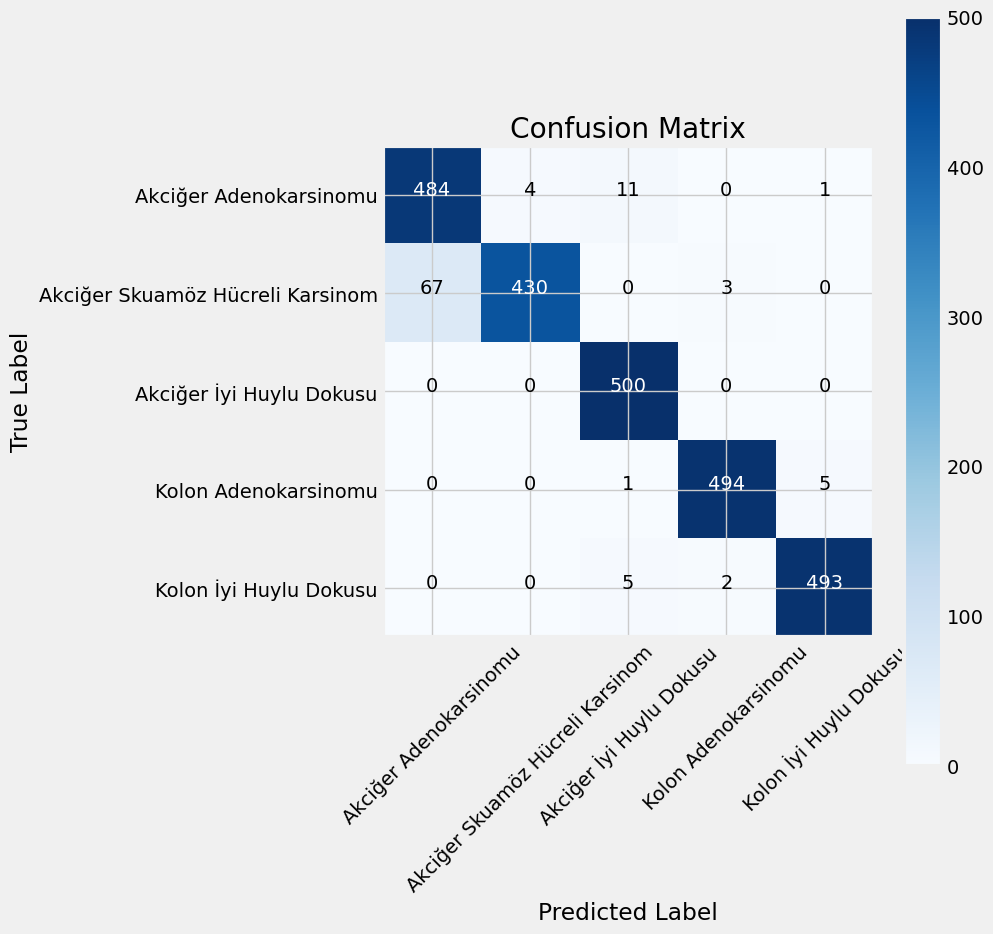

In [12]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix oluşturma.
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [13]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))


                                  precision    recall  f1-score   support

          Akciğer Adenokarsinomu       0.88      0.97      0.92       500
Akciğer Skuamöz Hücreli Karsinom       0.99      0.86      0.92       500
        Akciğer İyi Huylu Dokusu       0.97      1.00      0.98       500
            Kolon Adenokarsinomu       0.99      0.99      0.99       500
          Kolon İyi Huylu Dokusu       0.99      0.99      0.99       500

                        accuracy                           0.96      2500
                       macro avg       0.96      0.96      0.96      2500
                    weighted avg       0.96      0.96      0.96      2500



In [14]:
#modeli kaydetme
model.save('Model.h5')

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
loaded_model = tf.keras.models.load_model('Model.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [19]:
image_path = r"C:\Users\oem\lung_colon_image_set\colon_image_sets\colon_n\colonca1.jpeg"
image = Image.open(image_path)

# Resim işlenir
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

#modele yüklenir
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 1s 547ms/step
Kolon Adenokarsinomu
